## The Lazy Colleague

**Backstory**

It is very common to work in teams, but it is just as common to find a teammate who decides not to work. However, colleagues do not usually tell the boss, so this individual goes unnoticed. Zenda is supervising four employees, and it is known that one of them never works. But who is it?

**Finding the lazy employee**

The project Zenda's team is working on can only be completed if **at least three people** in the team are working. Let's model this situation in a circuit:
![circuit](./images/The%20Lazy%20Colleague_1.png)

In this diagram, the qubit $e_i$ refers to the $i$-th employee, which will take the value 1 if this employee is chosen to work on the project. The output state labelled result will take the value 0 if the project was not completed and 1 if it was. Let us imagine that employee $e_1$ is the one who does not work. Then, if we apply the operator to the state $\Ket{1}\Ket{1}\Ket{0}\Ket{1}\Ket{0}$ (that is, we select $e_1$,$e_2$  and $e_4$ for the project), the output will be $\Ket{1}\Ket{1}\Ket{0}\Ket{1}\Ket{0}$. As we can see, the last qubit is still $\Ket{0}$, i.e. the project has not been carried out. This is because there are only two employees that actually work on the project, and a minimum of three is required.

Zenda wants to know who the lazy worker is, executing as few projects as possible. For this reason, they ask you to help her with your quantum skills. You are asked to discover who the lazy employee is, using a single shot and a single call to the "Project execution" operator.

**Challenge code**

On one hand, you are asked to complete circuit (you only need to apply gates). You can only call the project_execution operator once, which is already incorporated in the template. On the other hand, you must complete process_output, which will take the output of your circuit and will return who the lazy guy is.

The project_execution function will be generated when testing the solution; if you want to experiment with the function output in the notebook, you can temporarily replace project_execution with an operator of the form qml.MultiControlledX(wires=['e1', 'e2', 'e4', 'result']). In this case, the absence of "e3" on the wires means that in this project, "e3" will be the lazy employee. Just remember to switch it back to project_execution before submitting, so that your function uses the correct project_execution during testing!

You may find it useful to do some tests in [Quirk](https://algassert.com/quirk) before you start coding.

**Output**
To judge this challenge, we will arbitrarily generate 5000 different projects (project_execution), which we will send one by one to the circuit to check that your prediction is correct ("e1", "e2", "e3" or "e4"). Therefore, in this case, there will be no public and private test cases. Good luck!

Grover solution

In [1]:
import json
import pennylane as qml
import pennylane.numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import array_to_latex

In [6]:
from qiskit.circuit.library import ZGate


def oracle(n, ignore_qb):
    ctrl_list = list(range(1,n))
    ctrl_list.remove(ignore_qb)
    mcz = ZGate().control(n-2)

    qc = QuantumCircuit(n)
    qc.x(0)
    qc.h(0)
    qc.barrier()#because we want to know which qubit is unconnected
    qc.x(range(1,n))
    qc.barrier()
    qc.mcx(ctrl_list,0)
    qc.append(mcz,range(1,n))#because we want to mark only one element without when the element not connected will be 1. In oracle matrix only one element will be mark when one element will be not connected (=0)
    qc.barrier()#because we want to know which qubit is unconnected
    qc.x(range(1,n))
    qc.barrier()
    qc.h(0)
    qc.x(0)
    return qc

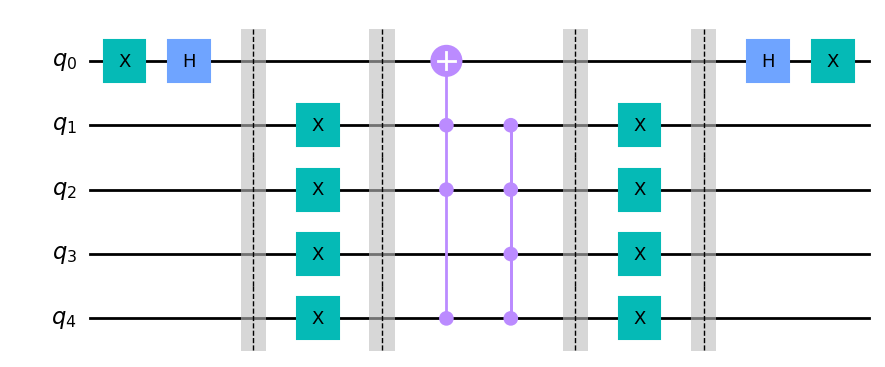

<IPython.core.display.Latex object>

In [7]:
n_qbs = 5
ignore_qb = np.random.randint(1,n_qbs)

oracle_cir = oracle(n_qbs,3)
display(oracle_cir.draw('mpl'))
op = Operator(oracle_cir).data
Uctr = op[::2,::2][:(2**n_qbs)//2,:(2**n_qbs)//2]
array_to_latex(Uctr,max_size=2**n_qbs)


In [8]:
def oracle(n, ignore_qb):
    ctrl_list = list(range(1,n))
    ctrl_list.remove(ignore_qb)

    mcz = ZGate().control(n-2)

    qc = QuantumCircuit(n, name='Uf (Oracle)')

    qc.x(range(1,n))
    qc.mcx(ctrl_list,0)
    qc.append(mcz,range(1,n))
    qc.x(range(1,n))

    return qc

In [9]:
def h_diffuser(n):
    mcz = ZGate().control(n-1)

    qc =QuantumCircuit(n, name='V (H Diffuser)', global_phase=np.pi)
    qc.h(range(n))
    qc.x(range(n))
    qc.append(mcz,range(n))
    qc.x(range(n))
    qc.h(range(n))

    return qc

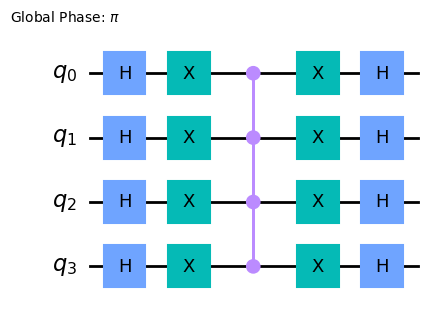

<IPython.core.display.Latex object>

In [10]:
n_qbs = 4
diff = h_diffuser(n_qbs)
display(diff.draw('mpl'))
array_to_latex(Operator(diff),max_size=2**n_qbs)

In [11]:
# Number of control qubits plus ancillary qubit for kickback
n_qbs = 5

#Find number of iterations:
rounds = np.round(np.pi/(4*np.arcsin(np.sqrt(1/(2**(n_qbs-1)))))-1/2,4)
rounds_int = int(np.round(rounds))
print(f'Number of rounds (exact, integer){tuple({rounds, rounds_int})}')

# Pick qubit at random to ignore
ignore_qb = np.random.randint(1,n_qbs)
print('disconnected qubit:', ignore_qb)

#create list showing the expected output string
output = [0]*n_qbs
output[ignore_qb] = 1
output = output[::-1]
output.pop()#remove kickback qubit
print(f'expected output {output}')

Number of rounds (exact, integer)(2.6083, 3)
disconnected qubit: 3
expected output [0, 1, 0, 0]


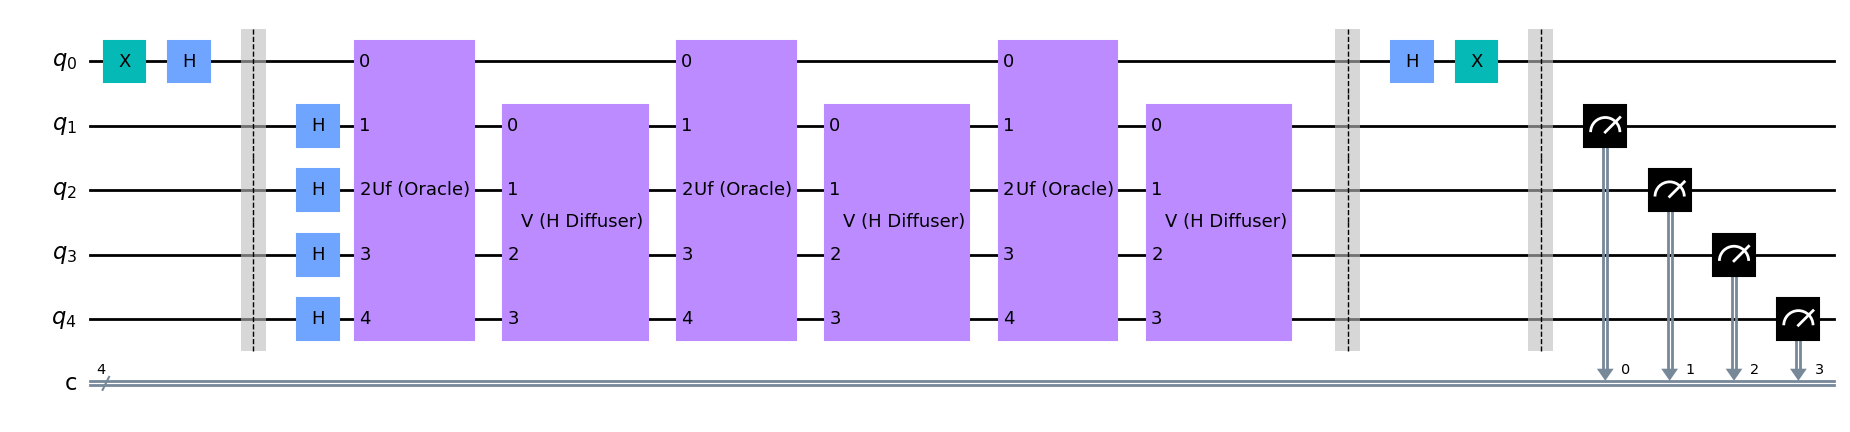

In [12]:
qc = QuantumCircuit(n_qbs,n_qbs-1)
# prepare minus state
qc.x(0)
qc.h(0)
qc.barrier()
# superposition
qc.h(range(1,n_qbs))

for r in range(rounds_int):
    qc.append(oracle(n_qbs,ignore_qb),range(n_qbs))
    qc.append(h_diffuser(n_qbs-1),range(1,n_qbs))

qc.barrier()
# uncomputing muinus state
qc.h(0)
qc.x(0)

qc.barrier()
qc.measure(range(1, n_qbs), range(n_qbs-1))
qc.draw('mpl',fold=50)

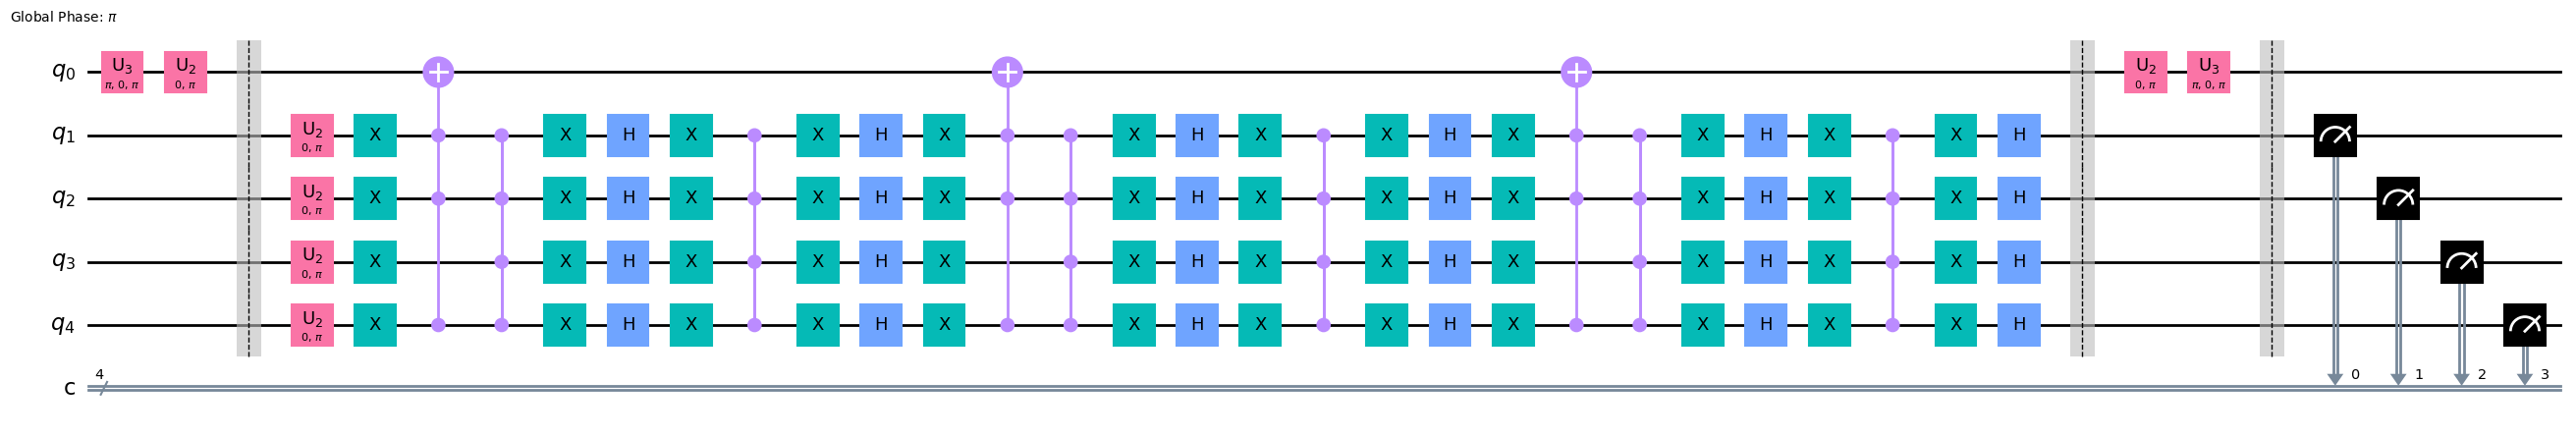

In [13]:
qc.decompose().draw('mpl',fold=50)

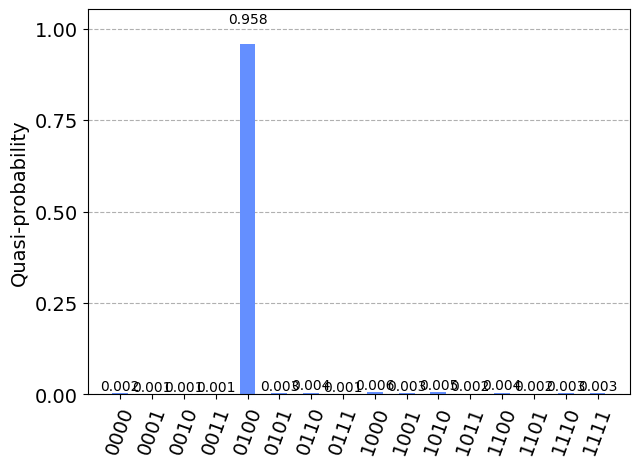

In [14]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_distribution
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, backend = simulator, shots = 2**11)
result = job.result()
counts = result.get_counts()
plot_distribution(counts)

[Generating Multi_QUbit W States in Qiskit](https://nbviewer.org/github/diemilio/quantum-playground/blob/main/w-states/w-states.ipynb#general)

In [15]:
def w_circ(n):
    prob_amp = np.sqrt(1/n)
    rot_ang = 2*np.arccos(prob_amp)

    qc_w = QuantumCircuit(n, name='W')

    # probability redistribution
    qc_w.ry(rot_ang,0)

    for i in range(1,n-1):
        comp_amp = np.sqrt(1-i/n)
        rot_ang = 2*np.arccos(prob_amp/(comp_amp))
        qc_w.cry(rot_ang,i-1,i)

    # state reshuffling
    for i in range(n-1,0,-1):
        qc_w.cx(i-1,i)

    qc_w.x(0)

    return qc_w

<IPython.core.display.Latex object>

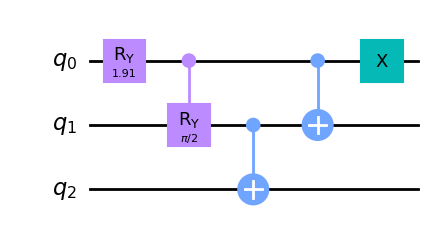

In [16]:
from qiskit.quantum_info import Statevector
qc = w_circ(3)
display(Statevector(qc).draw('latex'))
qc.draw('mpl')

In [17]:
def w_diffuser(n):
    mcz = ZGate().control(n-1)

    qc =QuantumCircuit(n, name='V (W Diffuser)', global_phase=np.pi)
    qc.append(w_circ(n).inverse(),range(n))
    qc.x(range(n))
    qc.append(mcz,range(n))
    qc.x(range(n))
    qc.append(w_circ(n),range(n))

    return qc

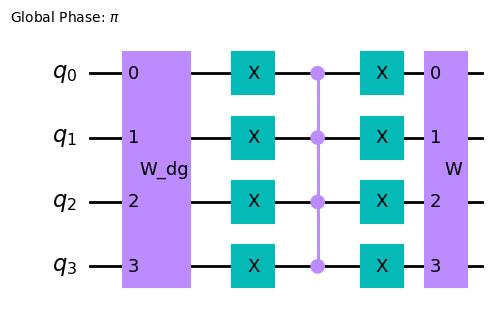

<IPython.core.display.Latex object>

In [18]:
n_qbs = 4
diff = w_diffuser(n_qbs)
display(diff.draw('mpl'))
array_to_latex(Operator(diff),max_size = 2**n_qbs)

In [19]:
def oracle(n, ignore_qb):
    ctrl_list = list(range(1,n))
    ctrl_list.remove(ignore_qb)

    qc = QuantumCircuit(n, name='Uf (Oracle)')
    qc.barrier()
    qc.x(range(1,n))
    qc.mcx(ctrl_list,0)
    qc.x(range(1,n))
    qc.barrier()

    return qc

In [20]:
# Number of control qubits plus ancillary qubit for kickback
n_qbs = 5

#Find number of iterations:
rounds = np.round(np.pi/(4*np.arcsin(np.sqrt(1/(n_qbs-1))))-1/2,4)
rounds_int = int(np.round(rounds))
print(f'Number of rounds (exact, integer){tuple({rounds, rounds_int})}')

# Pick qubit at random to ignore
ignore_qb = np.random.randint(1,n_qbs)
print('disconnected qubit:', ignore_qb)

#create list showing the expected output string
output = [0]*n_qbs
output[ignore_qb] = 1
output = output[::-1]
output.pop()#remove kickback qubit
print(f'expected output {output}')

Number of rounds (exact, integer)(1.0,)
disconnected qubit: 1
expected output [0, 0, 0, 1]


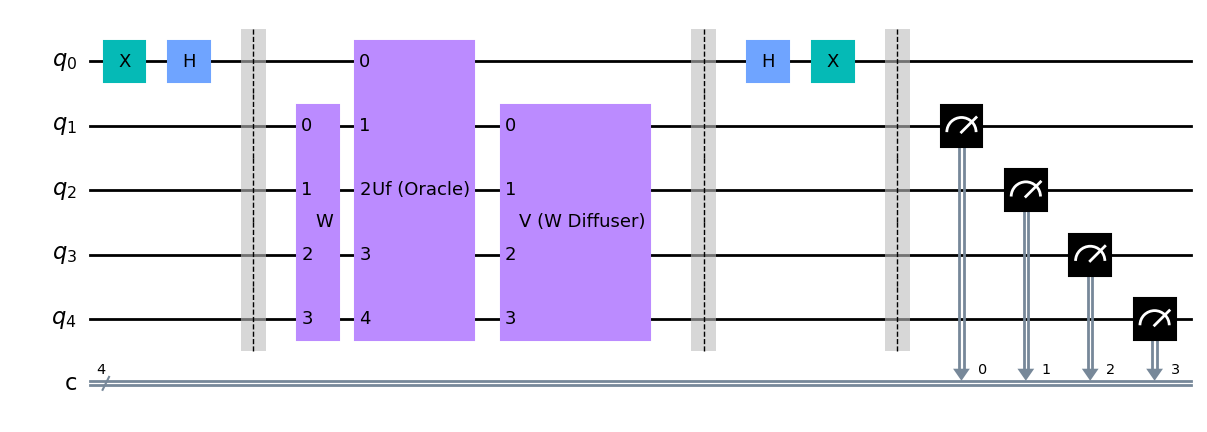

In [21]:
qc = QuantumCircuit(n_qbs,n_qbs-1)
# prepare minus state
qc.x(0)
qc.h(0)
qc.barrier()
# Prepare W state
qc.append(w_circ(n_qbs-1),range(1,n_qbs))

for r in range(rounds_int):
    qc.append(oracle(n_qbs,ignore_qb),range(n_qbs))
    qc.append(w_diffuser(n_qbs-1),range(1,n_qbs))

qc.barrier()
# uncomputing muinus state
qc.h(0)
qc.x(0)

qc.barrier()
qc.measure(range(1, n_qbs), range(n_qbs-1))
qc.draw('mpl',fold=50)

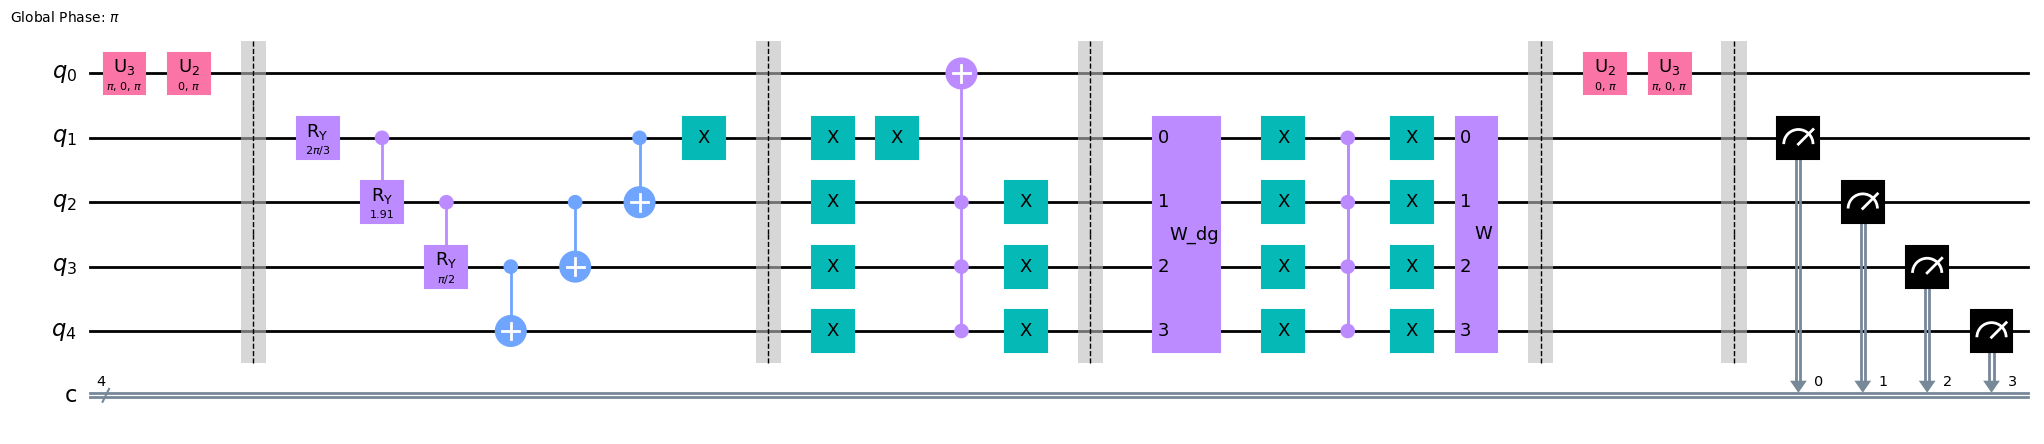

In [22]:
qc.decompose().draw('mpl',fold = 50)

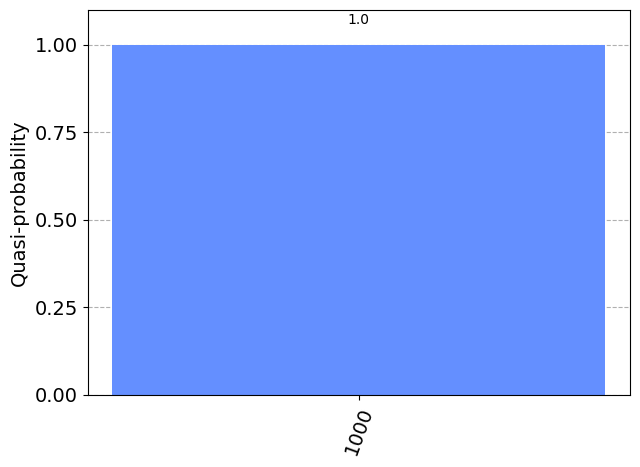

In [35]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, backend = simulator, shots = 1)
result = job.result()
counts = result.get_counts()
plot_distribution(counts)

Let's implement this in pennylane

In [2]:
import pennylane as qml
import pennylane.numpy as np

In [23]:
def w_circ(wires):
    n = len(wires)
    prob_amp = np.sqrt(1/n)
    rot_amp = 2*np.arccos(prob_amp)

    qml.PauliX(wires = wires[0])

    for i in range(0,n-1):
        comp_amp = np.sqrt(1-i/n)
        rot_ang = 2*np.arccos(prob_amp/(comp_amp))
        qml.CRY(rot_ang,wires=[wires[i],wires[i+1]])
        qml.CNOT(wires=[wires[i+1],wires[i]])

In [1]:
wires=["e1","e2","e3","e4","result"]

dev = qml.device("default.qubit",wires = wires,shots=1)
#dev.operations.add("op")

@qml.qnode(dev)
def circuit(project_execution):
    in_wires = ["e1","e2","e3","e4"]

    # prepare state |->
    qml.PauliX(wires="result")
    qml.Hadamard(wires="result")
    qml.Barrier(wires = wires)

    # Prepare input W-state
    w_circ(in_wires)
    qml.Barrier(wires=wires)

    # Oracle
    qml.broadcast(qml.PauliX,wires = in_wires,pattern='single')
    #project_execution(wires=wires)
    qml.MultiControlledX(wires = ["e1","e2","e4","result"]) # manually put lazy e3
    qml.broadcast(qml.PauliX,wires = in_wires,pattern='single')
    qml.Barrier(wires=wires)

    # Diffuser
    qml.adjoint(w_circ)(in_wires)
    qml.Barrier(wires=wires)
    qml.broadcast(qml.PauliX,wires = in_wires,pattern='single')
    qml.MultiControlledX(wires = wires)
    qml.broadcast(qml.PauliX,wires = in_wires,pattern='single')
    qml.Barrier(wires=wires)
    w_circ(in_wires)
    qml.Barrier(wires=wires)

    # uncompute state |->
    qml.Hadamard(wires = "result")
    qml.PauliX(wires = "result")

    return qml.sample(wires = in_wires)


NameError: name 'qml' is not defined

In [29]:
print(qml.draw(circuit)(0),'\n')
print(circuit(0))

    e1: ───────╭||──X─╭●────────╭X───────────────────────────╭||──X─╭●──X─╭||───────────────────
    e2: ───────├||────╰RY(2.09)─╰●─╭●────────╭X──────────────├||──X─├●──X─├||────────────────╭X†
    e3: ───────├||─────────────────╰RY(1.91)─╰●─╭●────────╭X─├||──X─│───X─├||─╭X†─╭●─────────╰●─
    e4: ───────├||──────────────────────────────╰RY(1.57)─╰●─├||──X─├●──X─├||─╰●──╰RY(1.57)†────
result: ──X──H─╰||───────────────────────────────────────────╰||────╰X────╰||───────────────────

─────────────╭X†─╭●──────────X†─╭||──X─╭●──X─╭||──X─╭●────────╭X───────────────────────────╭||───────┤
──╭●─────────╰●──╰RY(2.09)†─────├||──X─├●──X─├||────╰RY(2.09)─╰●─╭●────────╭X──────────────├||───────┤
──╰RY(1.91)†────────────────────├||──X─├●──X─├||─────────────────╰RY(1.91)─╰●─╭●────────╭X─├||───────┤
────────────────────────────────├||──X─├●──X─├||──────────────────────────────╰RY(1.57)─╰●─├||───────┤
────────────────────────────────╰||────╰X────╰||───────────────────────────────────────────╰||──H──X─┤

In [30]:
def process_output(measurement):
    for n, wire in enumerate(wires):
        if measurement[n]:
            return wire

In [31]:
process_output(circuit(0))

'e3'

Challenge

In [2]:
import json
import pennylane as qml
import pennylane.numpy as np

dev = qml.device("default.qubit.legacy", wires=["e1", "e2", "e3", "e4", "result"], shots=1)
dev.operations.add("op")

wires = ["e1", "e2", "e3", "e4", "result"]


@qml.qnode(dev)
def circuit(project_execution):
    """This is the circuit we will use to detect which is the lazy worker. Remember
    that we will only execute one shot.

    Args:
        project_execution (qml.ops):
            The gate in charge of marking in the last qubit if the project has been finished
            as indicated in the statement.

    Returns:
        (numpy.tensor): Measurement output in the 5 qubits after a shot.
    """
    in_wires = ["e1","e2","e3","e4"]
    def w_circ(wires):
        n = len(wires)
        prob_amp = np.sqrt(1/n)
        rot_amp = 2*np.arccos(prob_amp)

        qml.PauliX(wires = wires[0])

        for i in range(0,n-1):
            comp_amp = np.sqrt(1-i/n)
            rot_ang = 2*np.arccos(prob_amp/(comp_amp))
            qml.CRY(rot_ang,wires=[wires[i],wires[i+1]])
            qml.CNOT(wires=[wires[i+1],wires[i]])

    # prepare state |->
    qml.PauliX(wires="result")
    qml.Hadamard(wires="result")
    qml.Barrier(wires = wires)

    # Prepare input W-state
    w_circ(in_wires)
    qml.Barrier(wires=wires)

    # Oracle
    qml.broadcast(qml.PauliX,wires = in_wires,pattern='single')
    project_execution(wires=wires)
    qml.broadcast(qml.PauliX,wires = in_wires,pattern='single')
    qml.Barrier(wires=wires)

    # Diffuser
    qml.adjoint(w_circ)(in_wires)
    qml.Barrier(wires=wires)
    qml.broadcast(qml.PauliX,wires = in_wires,pattern='single')
    qml.MultiControlledX(wires = wires)
    qml.broadcast(qml.PauliX,wires = in_wires,pattern='single')
    qml.Barrier(wires=wires)
    w_circ(in_wires)
    qml.Barrier(wires=wires)

    # uncompute state |->
    qml.Hadamard(wires = "result")
    qml.PauliX(wires = "result")

    return qml.sample(wires=dev.wires)

def process_output(measurement):
    """This function will take the circuit measurement and process it to determine who is the lazy worker.

    Args:
        measurement (numpy.tensor): Measurement output in the 5 qubits after a shot.

    Returns:
        (str): This function must return "e1", "e2" "e3" or "e4" - the lazy worker.
    """
    for n, wire in enumerate(wires):
        if measurement[n]:
            return wire


# These functions are responsible for testing the solution.
# These functions are responsible for testing the solution.

def run(test_case_input: str) -> str:
    return None

def check(solution_output: str, expected_output: str) -> None:
    samples = 5000

    solutions = []
    output = []

    for s in range(samples):
        lazy = np.random.randint(0, 4)
        no_lazy = list(range(4))
        no_lazy.pop(lazy)

        def project_execution(wires):
            class op(qml.operation.Operator):
                num_wires = 5

                def compute_decomposition(self, wires):
                    raise ValueError("You cant descompose this gate")

                def matrix(self):
                    m = np.zeros([32, 32])
                    for i in range(32):
                        b = [int(j) for j in bin(64 + i)[-5:]]
                        if sum(np.array(b)[no_lazy]) == 3:
                            if b[-1] == 0:
                                m[i, i + 1] = 1
                            else:
                                m[i, i - 1] = 1
                        else:
                            m[i, i] = 1
                    return m

            op(wires=wires)
            return None

        out = circuit(project_execution)
        solutions.append(lazy + 1)
        output.append(int(process_output(out)[-1]))

    assert np.allclose(
        output, solutions, rtol=1e-4
    ), "Your circuit does not give the correct output."

    ops = [op.name for op in circuit.tape.operations]
    assert ops.count("op") == 1, "You have used the oracle more than one time."